In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets,transforms,models

In [2]:
import cv2 as cv
import numpy as np
# import pytesseract as tess
import glob
from sklearn.model_selection import train_test_split
import os

In [3]:
import matplotlib.pyplot as plt

### 参数设置

In [6]:
n_epochs = 5 # 模型训练5轮
log_interval = 30 #控制打印频率的，设n = 30*batch_size，即n张图后打印一次进度
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 根据设备是否支持GPU来选择硬件 
size = 32 # 对输入图片进行处理，拉伸为32*32的图片，这是为了复刻手写数字识别的神经网络，其输入为32*32的灰度图像
learn_rate = 0.03 # 学习率
momentum = 0.1  # 动量

In [7]:
'''
读取文件夹下所有图片，将其二值化
高斯核去掉噪音，然后使用OTSU算法二值化，再写入文件夹中
输入：需要处理的图像list
输出：二值化之后的图像list
'''
def binary_img(images):
    Gimg_list = []
    for i in range(len(images)):
        img = images[i]
        blur = cv.GaussianBlur(img,(5,5),0)
        ret,thImg = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)  #修改THRESH_BINARY
        Gimg_list.append(thImg) 
    return Gimg_list

In [8]:
'''
读取文件夹下的所有文件及图片，以灰度图的形式读取并resize到指定大小并且进行norm
输入：input_dir：读取的文件夹，可使用模糊匹配
输出：图像列表，图片的路径列表
'''
def readImgAPathWithNorm(input_dir,imgsize=32,Rmap=0):
    glob_dir = input_dir + '*.png'
    paths = [path for path in glob.glob(glob_dir)]
    if Rmap==0:
        images = [cv.resize(cv.imread(file,0),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    else:
        images = [cv.resize(cv.imread(file),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    images = binary_img(images)
    labels = [name.split(os.path.sep)[-2] for name in paths] #读取对应的路径
    images = np.array(images)/255 #将一张图归一化
    return images,labels

In [9]:
'''
读取文件夹下所有图片，将其二值化(不去噪)
使用OTSU算法二值化，再写入文件夹中
输入：需要处理的图像list
输出：二值化之后的图像list
'''
def binary_img_noBlur(images):
    Gimg_list = []
    for i in range(len(images)):
        img = images[i]
        ret,thImg = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)  #修改THRESH_BINARY
        Gimg_list.append(thImg) 
    return Gimg_list

In [10]:
'''
读取文件夹下的所有文件及图片，以灰度图的形式读取并resize到指定大小并且进行norm
输入：input_dir：读取的文件夹，可使用模糊匹配
输出：图像列表，图片标签
'''
def readImgAPathWithNorm_noBlur(input_dir,imgsize=32,Rmap=0):
    glob_dir = input_dir + '*.png'
    paths = [path for path in glob.glob(glob_dir)]
    if Rmap==0:
        images = [cv.resize(cv.imread(file,0),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    else:
        images = [cv.resize(cv.imread(file),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    images = binary_img_noBlur(images)
    labels = [name.split(os.path.sep)[-2] for name in paths] #读取对应的路径
    images = np.array(images)/255 #将一张图归一化
    return images,labels

In [11]:
'''
显示图片
输入：图片矩阵，画布大小：元组（宽，高）
'''
def showImg(img,figsize=(4,4),cmap = "gray"):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img,cmap = cmap)
    plt.show()

In [12]:
test_input_dir = "./result/temp_data/?/"
test_images,test_labels = readImgAPathWithNorm(test_input_dir)
# images_divert = [cv.bitwise_not(item) for item in test_images]  #反转图像黑白转换

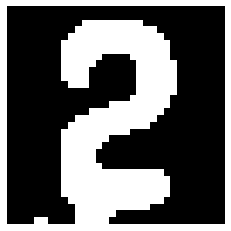

In [13]:
showImg(test_images[500])

In [14]:
test_input_dir = "./result/temp_data/?/"
test_images,test_labels = readImgAPathWithNorm(test_input_dir)

In [15]:
train_input_dir = "./result/augment_data/augment_mask_Gaussion/?/"
train_images,train_labels = readImgAPathWithNorm_noBlur(train_input_dir)

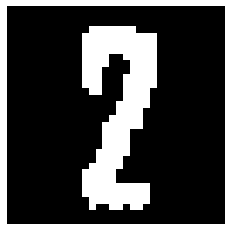

In [16]:
showImg(train_images[100])

In [17]:
train_x, val_x, train_y, val_y = train_test_split(train_images, train_labels, test_size = 0.1)

In [18]:
train_x.shape,val_x.shape

((1620, 32, 32), (180, 32, 32))

In [19]:
train_transforms = transforms.Compose([transforms.RandomRotation(5),
                                       transforms.Resize(32),
                                       transforms.ToTensor(), # 归一化  对图像进行张量化，以便神经网络处理
                                       transforms.Normalize((0.5,0.5,0.5),
                                                            (0.5,0.5,0.5)) #变换到【-1 ，1】
                                      ])


test_valid_transforms = transforms.Compose([
                                       transforms.Resize(32),
                                       transforms.ToTensor(), #归一化  对图像进行张量化，以便神经网络处理
                                       transforms.Normalize((0.5,0.5,0.5),
                                                            (0.5,0.5,0.5))
])

In [20]:
train_dir = "./result/augment_data/temp_train/"

# 使用预处理格式加载图像
train_data = datasets.ImageFolder(train_dir,transform = train_transforms)

In [21]:
test_dir = "./result/temp_data/"
test_data = datasets.ImageFolder(test_dir,transform = test_valid_transforms)
# valid_data = datasets.ImageFolder(valid_dir,transform = test_valid_transforms)

# 创建三个加载器，分别为训练，验证，测试，将训练集的batch大小设为64，即每次加载器向网络输送64张图片，随机打乱
trainloader = torch.utils.data.DataLoader(train_data,batch_size = 16,shuffle = True)
testloader = torch.utils.data.DataLoader(test_data,batch_size = 16)
# validloader = torch.utils.data.DataLoader(valid_data,batch_size = 20)

In [ ]:
classes = ("0","1")

In [22]:
def imshow(img):
    """
    展示图片
    img:图片数据
    """
    img = img / 2 + 0.5  # 反标准化
    npimg = img.numpy()  # 将数据转换成numpy格式
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 




In [23]:
# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
dataiter.next()

In [ ]:

# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(" ".join('%5s' % classes[labels[j]] for j in range(4))) 

In [6]:
#2个卷积层的神经网络
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),   #输入1通道，输出16通道，其实代表卷积核的个数为16
            nn.BatchNorm2d(16),                                     #输入1通道，输出16通道，其实代表卷积核的个数为16
            nn.ReLU(),                                              #激励函数处理
            nn.MaxPool2d(kernel_size=2, stride=2))                  #最大池化，降采样   2x2 步长为2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, output_size)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)    #将输出7*7*32拉成一个张量，size(0)，返回行数，view（行数，-1），reshape成多少行数，列数模糊控制不管。
        out = self.fc(out)
        return out

model = ConvNet().to(device)

NameError: name 'nn' is not defined

In [ ]:


# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#训练模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# 测试模型
model.eval()    #把模型设置成验证模式
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  ##data是一个以两个张量为元素的列表
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# 保存模型
torch.save(model.state_dict(), 'model.pkl')
#
X_test, y_test = next(iter(test_loader))
inputs = Variable(X_test)
pred = model(inputs)
_, pred = torch.max(pred, 1)

print("Predict Label is:", (i for i in pred))
print("Real Label is :", [i for i in y_test])

img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1, 2, 0)

std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
img = img * std + mean
cv2.imshow('win', img)
key_pressed = cv2.waitKey(0)